In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.core.common import flatten

In [4]:
data_path = "../data/uci_data.xls"

In [5]:
df = pd.read_excel(data_path, header=0, index_col=0, skiprows=1)

In [6]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
train

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
21754,80000,2,2,2,24,0,0,0,0,0,...,73731,39643,39457,3503,5001,2092,1218,1445,878,0
252,30000,1,2,2,28,0,0,0,0,0,...,25255,22001,0,5006,1244,851,955,0,0,0
22942,180000,2,5,1,44,0,0,-1,-1,-1,...,0,6881,10340,0,850,0,6881,10340,182,0
619,60000,1,1,2,25,0,0,0,0,0,...,39639,39619,39140,2018,1900,2000,1500,1900,2000,0
17091,130000,2,2,2,25,0,0,0,0,0,...,117823,120854,123904,4100,4200,5000,5000,5000,10700,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29803,50000,1,2,2,32,0,0,0,0,0,...,55957,29238,6119,2000,3000,1591,72,1134,73421,0
5391,200000,1,1,2,37,2,2,2,2,2,...,164182,169029,172084,13500,6000,0,7500,6000,4000,1
861,50000,1,1,2,26,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0


# Check for missing data

In [8]:
train.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

# Check for non valid values

In [19]:
sex_bad = train[~train['SEX'].isin([1,2])]
len(sex_bad.index)

0

In [23]:
edu_bad = train[~(train['EDUCATION'].isin([1, 2, 3, 4]))]
len(edu_bad.index)

277

In [25]:
mar_bad = train[~(train['MARRIAGE'].isin([1, 2, 3]))]
len(mar_bad.index)

45

In [26]:
age_bad = train[(train['AGE']<0) | (train['AGE']>100)]
len(age_bad.index)

0

In [29]:
p0_bad = train[~(train['PAY_0'].isin([-1,0,1,2,3,4,5,6,7,8,9]))]
p1_bad = train[~(train['PAY_1'].isin([-1,0,1,2,3,4,5,6,7,8,9]))]
p0_bad = train[~(train['PAY_0'].isin([-1,0,1,2,3,4,5,6,7,8,9]))]
p1_bad = train[~(train['PAY_1'].isin([-1,0,1,2,3,4,5,6,7,8,9]))]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
22654,360000,2,3,1,43,-2,-2,-2,-2,-2,...,15584,3195,4261,805,1071,15604,3195,4269,3525,0
20534,320000,1,1,2,29,-2,-2,-2,-2,-2,...,17439,66408,14333,28524,13270,17562,66751,14405,52677,0
1257,230000,1,1,2,26,-2,-2,-2,-2,-2,...,416,566,416,371,461,416,566,416,0,0
23258,290000,2,2,2,38,-2,-2,-2,-1,0,...,24756,25147,25685,130,0,24756,899,942,927,0
3837,240000,2,2,2,27,-2,-2,-1,2,0,...,1129,1971,2059,0,1129,0,1000,496,1000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1686,230000,2,1,1,61,-2,-2,-2,-2,-2,...,1443,1443,1443,1443,1443,1443,1443,1443,1443,0
21963,150000,2,1,2,27,-2,-2,-2,-1,0,...,59350,41136,28596,3449,46128,60260,30218,17000,20133,0
29911,310000,1,2,2,30,-2,-2,-2,-2,-2,...,0,0,291,0,1003,0,0,291,173,0


# Get the shape of the data

In [7]:
cat = ["SEX", "EDUCATION", "MARRIAGE", "PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
num = ["LIMIT_BAL", "AGE", 
       "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6", 
       "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]

## Categorical Features

PAY_0 ... PAY_6:
-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

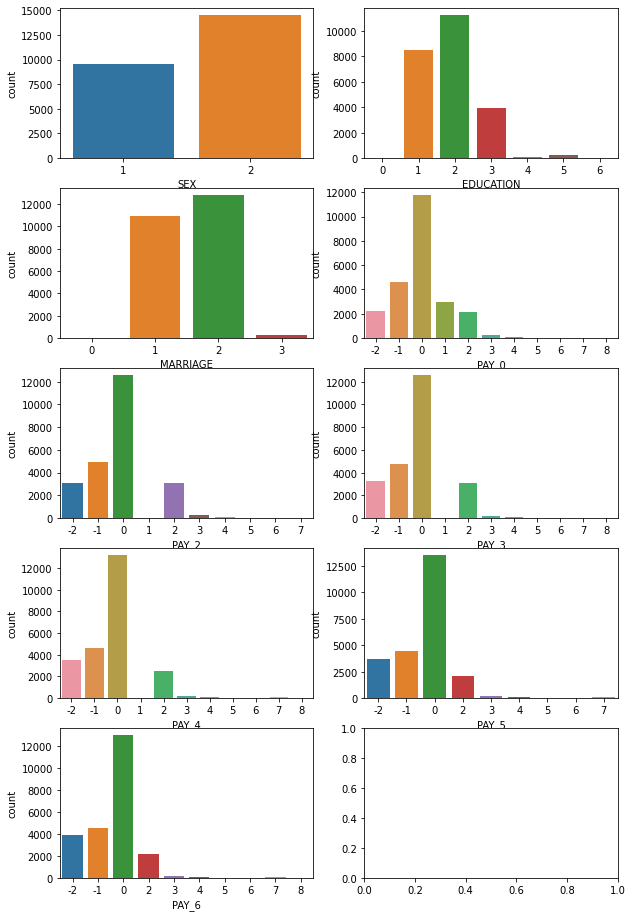

In [8]:
fig, axs = plt.subplots(5, 2, figsize=(10, 16))

for ax,c in zip(list(flatten(axs)), cat):
    sns.countplot(x=c, data=train, ax=ax)

## Numerical Features

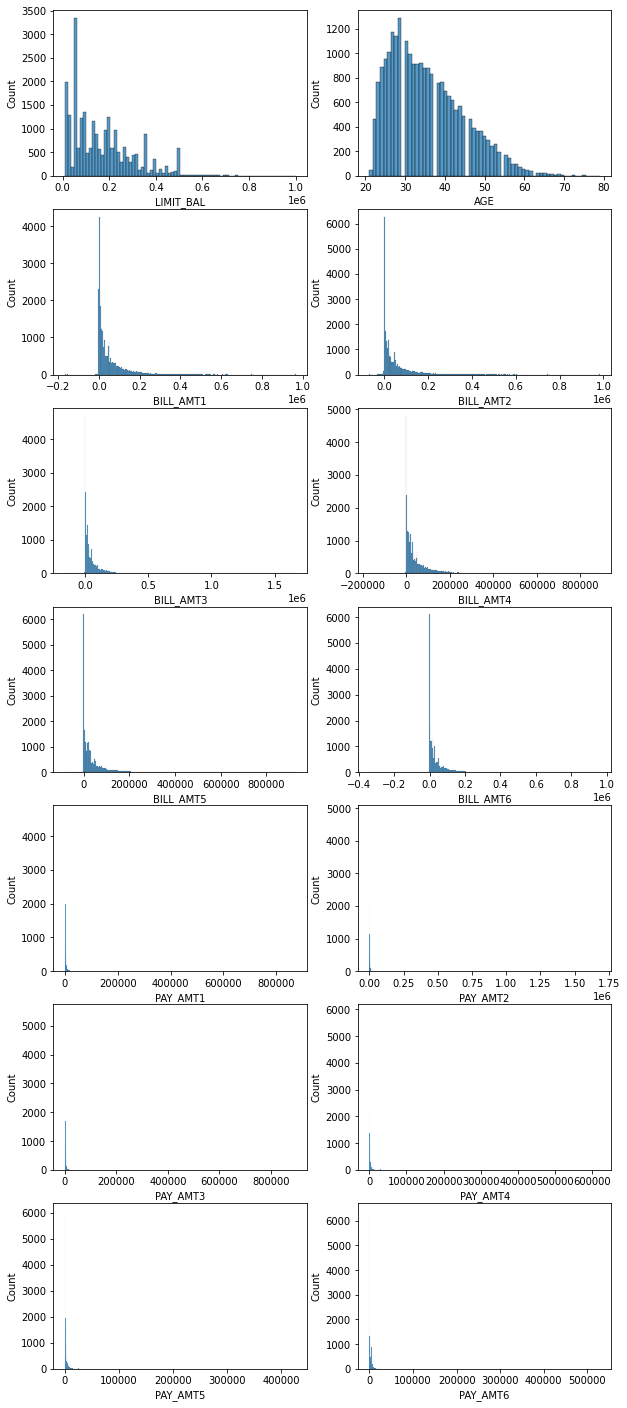

In [9]:
fig, axs = plt.subplots(7, 2, figsize=(10, 25))

for ax,c in zip(list(flatten(axs)), num):
    sns.histplot(x=c, data=train, ax=ax)

# Spot Outliers

It is generally possible for a credit card customer to overpay their bill and temporarily carry a negative balance. E.g., say my bill this month is \\$100 but I pay \\$250. Assuming I have no other recent purchases, my balance will be -\\$150.

As for why a customer might do this, maybe their autopay is set up to pay the same amount every month regardless of balance, maybe they forgot if they paid their bill one month and accidentally paid twice, or maybe they just like to pay down some future expected purchases in advance. Payment behavior like this may not always appear rational, but it is not uncommon. 

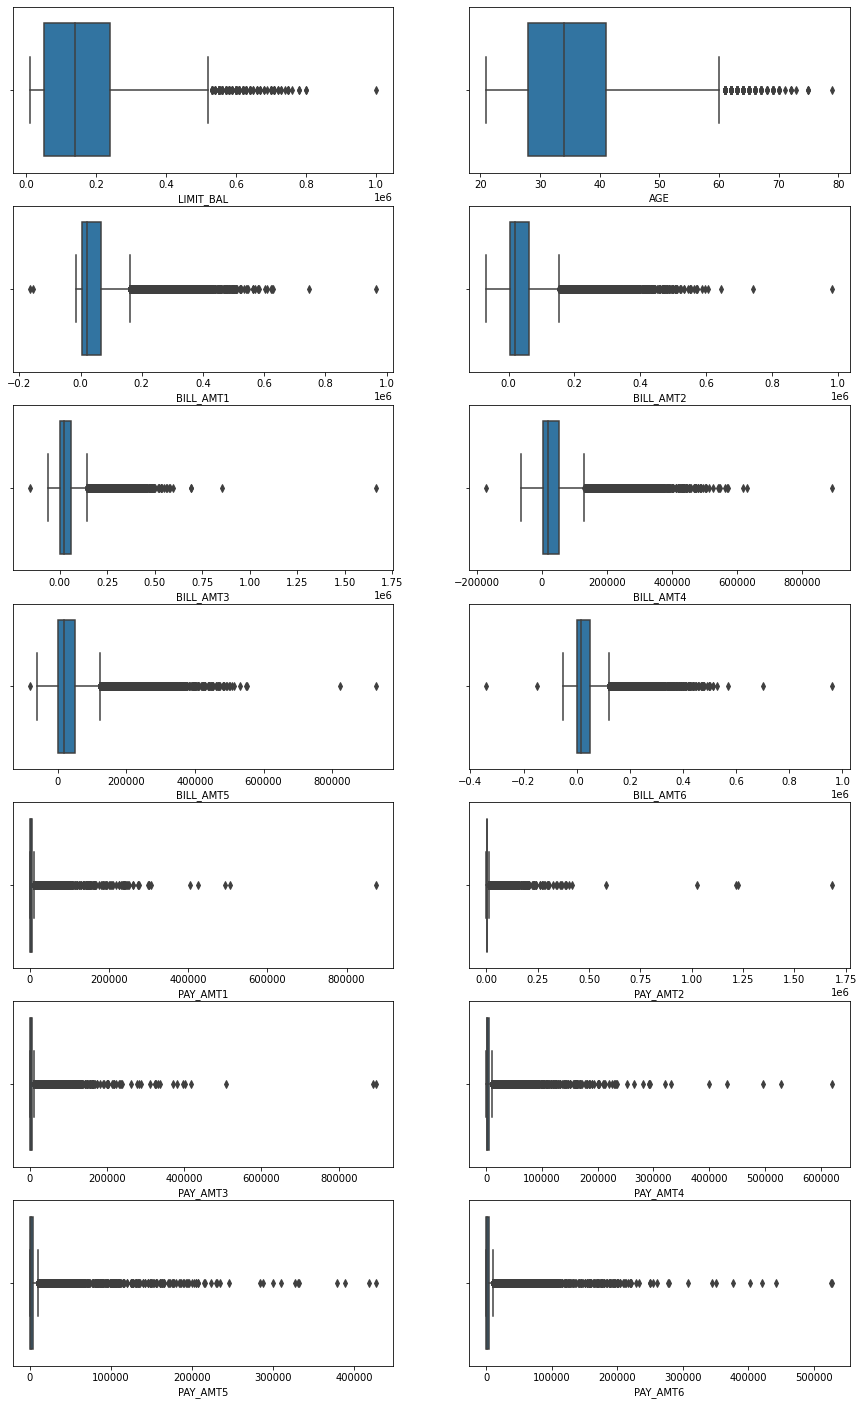

In [10]:
fig, axs = plt.subplots(7, 2, figsize=(15, 25))

for ax,c in zip(list(flatten(axs)), num):
    sns.boxplot(x=c, data=train, ax=ax)

# Identify correlations

<AxesSubplot:>

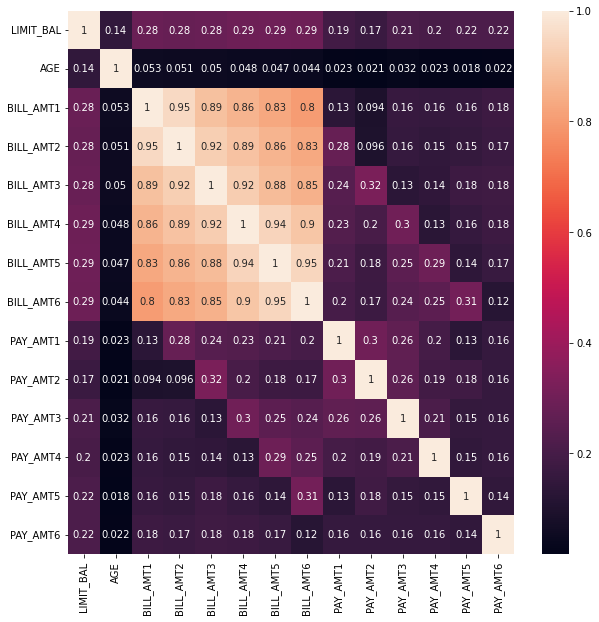

In [11]:
corrMatrix = train[num].corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=True, ax=ax)

ModuleNotFoundError: No module named 'imblearn'